In [24]:
import random
import numpy as np
from tqdm import tqdm
import torch
import math
import os
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
from IPython.display import clear_output
from torchrl.modules.distributions import MaskedCategorical
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt

In [27]:
# -*- coding: utf-8 -*-
"""Segment tree for Prioritized Replay Buffer."""

import operator
from typing import Callable


class SegmentTree:
    """ Create SegmentTree.

    Taken from OpenAI baselines github repository:
    https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py

    Attributes:
        capacity (int)
        tree (list)
        operation (function)

    """

    def __init__(self, capacity: int, operation: Callable, init_value: float):
        """Initialization.

        Args:
            capacity (int)
            operation (function)
            init_value (float)

        """
        assert (
            capacity > 0 and capacity & (capacity - 1) == 0
        ), "capacity must be positive and a power of 2."
        self.capacity = capacity
        self.tree = [init_value for _ in range(2 * capacity)]
        self.operation = operation

    def _operate_helper(
        self, start: int, end: int, node: int, node_start: int, node_end: int
    ) -> float:
        """Returns result of operation in segment."""
        if start == node_start and end == node_end:
            #print(node)
            return self.tree[node]
        mid = (node_start + node_end) // 2
        if end <= mid:
            return self._operate_helper(start, end, 2 * node, node_start, mid)
        else:
            if mid + 1 <= start:
                return self._operate_helper(start, end, 2 * node + 1, mid + 1, node_end)
            else:
                return self.operation(
                    self._operate_helper(start, mid, 2 * node, node_start, mid),
                    self._operate_helper(mid + 1, end, 2 * node + 1, mid + 1, node_end),
                )

    def operate(self, start: int = 0, end: int = 0) -> float:
        """Returns result of applying `self.operation`."""
        if end <= 0:
            end += self.capacity
        end -= 1

        return self._operate_helper(start, end, 1, 0, self.capacity - 1)

    def __setitem__(self, idx: int, val: float):
        """Set value in tree."""
        idx += self.capacity
        self.tree[idx] = val

        idx //= 2
        while idx >= 1:
            self.tree[idx] = self.operation(self.tree[2 * idx], self.tree[2 * idx + 1])
            idx //= 2

    def __getitem__(self, idx: int) -> float:
        """Get real value in leaf node of tree."""
        assert 0 <= idx < self.capacity

        return self.tree[self.capacity + idx]


class SumSegmentTree(SegmentTree):
    """ Create SumSegmentTree.

    Taken from OpenAI baselines github repository:
    https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py

    """

    def __init__(self, capacity: int):
        """Initialization.

        Args:
            capacity (int)

        """
        super(SumSegmentTree, self).__init__(
            capacity=capacity, operation=operator.add, init_value=0.0
        )

    def sum(self, start: int = 0, end: int = 0) -> float:
        """Returns arr[start] + ... + arr[end]."""
        return super(SumSegmentTree, self).operate(start, end)

    def retrieve(self, upperbound: float) -> int:
        """Find the highest index `i` about upper bound in the tree"""
        assert 0 <= upperbound <= self.sum() + 1e-5, "upperbound: {}".format(upperbound)

        idx = 1

        while idx < self.capacity:  # while non-leaf
            left = 2 * idx
            right = left + 1
            if self.tree[left] > upperbound:
                idx = 2 * idx
            else:
                upperbound -= self.tree[left]
                idx = right
        return idx - self.capacity


class MinSegmentTree(SegmentTree):
    """ Create SegmentTree.

    Taken from OpenAI baselines github repository:
    https://github.com/openai/baselines/blob/master/baselines/common/segment_tree.py

    """

    def __init__(self, capacity: int):
        """Initialization.

        Args:
            capacity (int)

        """
        super(MinSegmentTree, self).__init__(
            capacity=capacity, operation=min, init_value=float("inf")
        )

    def min(self, start: int = 0, end: int = 0) -> float:
        """Returns min(arr[start], ...,  arr[end])."""
        return super(MinSegmentTree, self).operate(start, end)

In [28]:
class NoisyLinear(nn.Module):

    def __init__(self, in_features: int, out_features: int, std_init: float = 0.5):
        """Initialization."""
        super(NoisyLinear, self).__init__()

        self.in_features = in_features
        self.out_features = out_features
        self.std_init = std_init

        self.weight_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.weight_sigma = nn.Parameter(
            torch.Tensor(out_features, in_features)
        )
        self.register_buffer(
            "weight_epsilon", torch.Tensor(out_features, in_features)
        )

        self.bias_mu = nn.Parameter(torch.Tensor(out_features))
        self.bias_sigma = nn.Parameter(torch.Tensor(out_features))
        self.register_buffer("bias_epsilon", torch.Tensor(out_features))

        self.reset_parameters()
        self.reset_noise()

    def reset_parameters(self):
        """Reset trainable network parameters (factorized gaussian noise)."""
        mu_range = 1 / math.sqrt(self.in_features)
        self.weight_mu.data.uniform_(-mu_range, mu_range)
        self.weight_sigma.data.fill_(
            self.std_init / math.sqrt(self.in_features)
        )
        self.bias_mu.data.uniform_(-mu_range, mu_range)
        self.bias_sigma.data.fill_(
            self.std_init / math.sqrt(self.out_features)
        )

    def reset_noise(self):
        """Make new noise."""
        epsilon_in = self.scale_noise(self.in_features)
        epsilon_out = self.scale_noise(self.out_features)

        # outer product
        self.weight_epsilon.copy_(epsilon_out.ger(epsilon_in))
        self.bias_epsilon.copy_(epsilon_out)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Forward method implementation.
        
        We don't use separate statements on train / eval mode.
        It doesn't show remarkable difference of performance.
        """
        return F.linear(
            x,
            self.weight_mu + self.weight_sigma * self.weight_epsilon,
            self.bias_mu + self.bias_sigma * self.bias_epsilon,
        )
    
    @staticmethod
    def scale_noise(size: int) -> torch.Tensor:
        """Set scale to make noise (factorized gaussian noise)."""
        x = torch.randn(size)

        return x.sign().mul(x.abs().sqrt())

In [29]:
#Define env
from pettingzoo.classic import connect_four_v3
env = connect_four_v3.env()

In [30]:
class ActorNet(nn.Module):
    def __init__(self):
        super(ActorNet, self).__init__()
        self.layer = nn.Sequential(
            nn.Conv2d(in_channels=2, out_channels=8, kernel_size=2), #Input 6x7 #Out 5x6
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=2), #In 5x6 #Out 4x5
            nn.Flatten(),
        )
        self.feature = nn.Linear(160, 128)
        self.noisy_layer1 = NoisyLinear(128, 128)
        self.noisy_layer2 = NoisyLinear(128, 7)

    def forward(self, x):
        x = self.layer(x)
        feature = F.relu(self.feature(x))
        hidden = F.relu(self.noisy_layer1(feature))
        out = self.noisy_layer2(hidden)
        return out
    def reset_noise(self):
        """Reset all noisy layers."""
        self.noisy_layer1.reset_noise()
        self.noisy_layer2.reset_noise()

In [31]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, mask, action, reward, next_state, next_mask, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, mask, action, reward, next_state, next_mask, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, mask, action, reward, next_state, next_mask, done = map(np.stack, zip(*batch))
        return state, mask, action, reward, next_state, next_mask, done
    
    def __len__(self):
        return len(self.buffer)

In [32]:
class PrioritizedReplayBuffer(ReplayBuffer): 
    def __init__(self, capacity, alpha: float = 0.6
    ):
        """Initialization."""
        assert alpha >= 0
        
        super(PrioritizedReplayBuffer, self).__init__(capacity)
        self.max_priority, self.tree_ptr = 1.0, 0
        self.alpha = alpha
    
        # capacity must be positive and a power of 2.
        #
        self.max_size = 150000
        tree_capacity = 1
        while tree_capacity < self.max_size:
            tree_capacity *= 2

        self.sum_tree = SumSegmentTree(tree_capacity)
        self.min_tree = MinSegmentTree(tree_capacity)
        
    def push(
        self, state, mask, action, reward, next_state, next_mask, done
    ):
        """Store experience and priority."""
        super().push(state, mask, action, reward, next_state, next_mask, done)
        
        self.sum_tree[self.tree_ptr] = self.max_priority ** self.alpha
        self.min_tree[self.tree_ptr] = self.max_priority ** self.alpha
        self.tree_ptr = (self.tree_ptr + 1) % self.max_size

    def sample(self, batch_size, beta: float = 0.4) -> Dict[str, np.ndarray]:
        """Sample a batch of experiences."""
        
        indices = self._sample_proportional(batch_size)
        experience_subset = []
        for idx in indices:
            experience_subset.append(self.buffer[idx])
        # Convert each element in experience_subset to NumPy array
        states = np.array([exp[0] for exp in experience_subset])
        masks = np.array([exp[1] for exp in experience_subset])
        actions = np.array([exp[2] for exp in experience_subset])
        rewards =  np.array([exp[3] for exp in experience_subset])
        next_states =  np.array([exp[4] for exp in experience_subset])
        next_masks =  np.array([exp[5] for exp in experience_subset])
        dones =  np.array([exp[6] for exp in experience_subset])
        weights =  np.array([self._calculate_weight(i, beta) for i in indices])
        return states, masks, actions, rewards, next_states, next_masks, dones, weights, indices
        
    def update_priorities(self, indices: List[int], priorities: np.ndarray):
        """Update priorities of sampled transitions."""
        assert len(indices) == len(priorities)
        for idx, priority in zip(indices, priorities):
            assert max(priority) > 0
            assert 0 <= idx < len(self)
            self.sum_tree[idx] = max(priority) ** self.alpha
            self.min_tree[idx] = max(priority) ** self.alpha
            self.max_priority = max(self.max_priority, max(priority))
            
    def _sample_proportional(self, batch_size) -> List[int]:
        """Sample indices based on proportions."""
        indices = []
        p_total = self.sum_tree.sum(0, len(self) - 1)
        segment = p_total / batch_size
        for i in range(batch_size):
            a = segment * i
            b = segment * (i + 1)
            
            upperbound = random.uniform(a, b)
            idx = self.sum_tree.retrieve(upperbound)
            indices.append(idx)
        return indices
    
    def _calculate_weight(self, idx: int, beta: float):
        """Calculate the weight of the experience at idx."""
        # get max weight
        p_min = self.min_tree.min() / self.sum_tree.sum()
        max_weight = (p_min * len(self)) ** (-beta)
        
        # calculate weights
        p_sample = self.sum_tree[idx] / self.sum_tree.sum()
        weight = (p_sample * len(self)) ** (-beta)
        weight = weight / max_weight
        
        return weight

In [35]:
class DQN:
    def __init__(self):
        self.q_network = ActorNet().to(device)
        self.opt_q = torch.optim.AdamW(self.q_network.parameters(), lr=0.001)
        self.replay_buffer_size = 100000
        self.replay_buffer =PrioritizedReplayBuffer(self.replay_buffer_size)
        self.MSE = torch.nn.MSELoss()
        self.batch_size = 128
        self.epsilon = 1/10
        self.gamma = 0.99
        self.prior_eps = 1e-6
        
    def update(self):
        state, mask, action, reward, next_state, next_mask, termination, weights, indices = self.replay_buffer.sample(self.batch_size)
        weights = torch.FloatTensor(weights.reshape(-1, 1)).to(device)
        state =  torch.tensor(state.reshape(-1, 2, 6,7)).to(device).float()
        next_state =  torch.tensor(next_state.reshape(-1, 2, 6, 7)).to(device).float()
        final_state_check = torch.tensor((1-termination)).to(device)
        reward = torch.tensor(reward).to(device)
        action = torch.LongTensor(action.reshape(-1, 1)).to(device)
        done = torch.FloatTensor(termination.reshape(-1, 1)).to(device)
        curr_q_value = self.q_network(state)[torch.arange(self.batch_size), action]
        next_q_value = self.q_network(next_state).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(device)
        elementwise_loss = F.smooth_l1_loss(curr_q_value, target, reduction="none") #Or use MSE
        loss = torch.mean(elementwise_loss * weights)
        #end of update dqn 
        self.opt_q.zero_grad()
        loss.backward()
        self.q_network.reset_noise()
        self.opt_q.step()
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        self.replay_buffer.update_priorities(indices, new_priorities)
        return loss.item()
    
    def update_given_buffer(self, replay_buffer):
        state, mask, action, reward, next_state, next_mask, termination, weights, indices = replay_buffer.sample(self.batch_size)
        weights = torch.FloatTensor(weights.reshape(-1, 1)).to(device)
        state =  torch.tensor(state.reshape(-1, 2, 6,7)).to(device).float()
        next_state =  torch.tensor(next_state.reshape(-1, 2, 6, 7)).to(device).float()
        final_state_check = torch.tensor((1-termination)).to(device)
        reward = torch.tensor(reward).to(device)
        action = torch.LongTensor(action.reshape(-1, 1)).to(device)
        done = torch.FloatTensor(termination.reshape(-1, 1)).to(device)
        curr_q_value = self.q_network(state)[torch.arange(self.batch_size), action]
        next_q_value = self.q_network(next_state).max(dim=1, keepdim=True)[0].detach()
        mask = 1 - done
        target = (reward + self.gamma * next_q_value * mask).to(device)
        elementwise_loss = F.smooth_l1_loss(curr_q_value, target, reduction="none")
        loss = torch.mean(elementwise_loss * weights)
        self.opt_q.zero_grad()
        loss.backward()
        self.q_network.reset_noise()
        self.opt_q.step()
        loss_for_prior = elementwise_loss.detach().cpu().numpy()
        new_priorities = loss_for_prior + self.prior_eps
        replay_buffer.update_priorities(indices, new_priorities)
        return loss.item()   

    def choose_action(self, state, greedy= False):
        mask = state["action_mask"]
        indices_of_ones = np.where(mask == 1)[0]
        action_random = np.random.choice(indices_of_ones)
        mask = torch.tensor(np.where( mask==0, -np.infty, 0), dtype=torch.float32).to(device).float()
        state = torch.tensor(state['observation'].reshape(1, 2, 6, 7)).to(device).float()
        logits = self.q_network(state)
        action_greedy = torch.argmax(mask + logits).tolist()
        if greedy:
            return action_greedy
        return np.random.choice([action_random, action_greedy], p=[self.epsilon, 1-self.epsilon])

# Train with Random Agents

In [20]:
agent_1 = DQN()

In [21]:
agent_1 = DQN()
gamma = 1
returns = []
losses_agent1 = []
rewards_agent1 = []
greedy_agents = False
episodes = 10_000
episode_lengths = []
for episode in tqdm(range(episodes)):
    env.reset()
    #p0
    observation_p0, reward, termination, truncation, info = env.last()
    env.step(env.action_space("player_0").sample(observation_p0["action_mask"]))
    #p1
    observation_p1, reward, termination, truncation, info = env.last()
    action_p1 = agent_1.choose_action(observation_p1, greedy=greedy_agents)
    env.step(action_p1)
    #
    for agent in env.agent_iter():
        ######
        observation_p0_prime, reward, termination, truncation, info = env.last()
        #Update
        observation_p0 = observation_p0_prime
        #Choose action for player 0 
        if termination or truncation:
            #Update p1 and end
            env.step(None)
            observation_p1_prime, reward, termination, truncation, info = env.last()
            agent_1.replay_buffer.push(observation_p1["observation"],observation_p1["action_mask"], action_p1, reward, observation_p1_prime["observation"],observation_p1_prime["action_mask"], termination)
            rewards_agent1+= [reward]
            break
        #
        env.step(env.action_space("player_0").sample(observation_p0["action_mask"]))
        ##################################################################
        observation_p1_prime, reward, termination, truncation, info = env.last()
        #Update
        agent_1.replay_buffer.push(observation_p1["observation"],observation_p1["action_mask"], action_p1, reward, observation_p1_prime["observation"],observation_p1_prime["action_mask"], termination)
        rewards_agent1+=[reward]
        observation_p1 = observation_p1_prime
        #Choose action for player 1
        if termination or truncation:
            #Update p0 and end
            env.step(None)
            break
        action_p1 = agent_1.choose_action(observation_p1, greedy=greedy_agents)
        env.step(action_p1)
        #################
        if len(agent_1.replay_buffer) > agent_1.batch_size:
            loss = agent_1.update()
            losses_agent1 += [loss]
env.close()

100%|██████████| 10000/10000 [30:52<00:00,  5.40it/s]


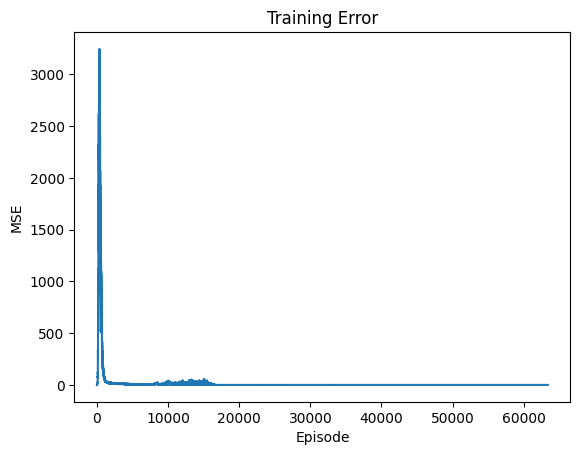

<Figure size 640x480 with 0 Axes>

In [37]:
plt.plot(losses_agent1)
plt.xlabel("Episode")
plt.ylabel("MSE")
plt.title("Training Error")
plt.show()
plt.savefig("random_connect4_dqn_training_error.png", bbox_inches='tight')

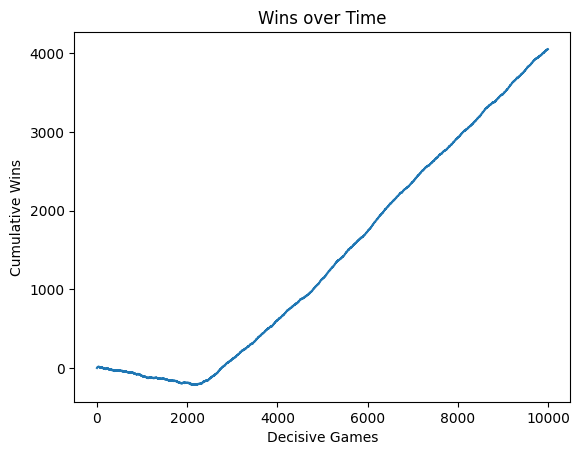

In [38]:
arr = [i for i in rewards_agent1 if i != 0]

plt.plot([sum(arr[:i]) for i in range(len(arr))])
plt.xlabel("Decisive Games")
plt.ylabel("Cumulative Wins")
plt.title("Wins over Time")
plt.savefig("random_connect4_dqn_cumuWins.png", bbox_inches='tight')

# Train DQN Agents Against Each Other

In [48]:
agent_0 = DQN()
agent_1 = DQN()

In [49]:
gamma = 1
returns = []
losses_agent0 = []
losses_agent1 = []
rewards_agent0 = []
rewards_agent1 = []
greedy_agents = False
episodes = 50_000
#env = connect_four_v3.env(render_mode="human")
episode_lengths = []
for episode in tqdm(range(episodes)):
    env.reset()
    #First action for p0
    observation_p0, reward, termination, truncation, info = env.last()
    action_p0 = agent_0.choose_action(observation_p0, greedy=greedy_agents)
    env.step(action_p0)
    #First action for p1
    observation_p1, reward, termination, truncation, info = env.last()
    action_p1 = agent_1.choose_action(observation_p1, greedy=greedy_agents)
    env.step(action_p1)
    for agent in env.agent_iter():
        observation_p0_prime, reward, termination, truncation, info = env.last()
        #Update
        agent_0.replay_buffer.push(observation_p0["observation"], observation_p0["action_mask"], action_p0, reward, observation_p0_prime["observation"], observation_p0_prime["action_mask"], termination)
        rewards_agent0 += [reward]
        observation_p0 = observation_p0_prime
        #Choose action for player 0 
        if termination or truncation:
            #Update p1 and end
            env.step(None)
            observation_p1_prime, reward, termination, truncation, info = env.last()
            agent_1.replay_buffer.push(observation_p1["observation"],observation_p1["action_mask"], action_p1, reward, observation_p1_prime["observation"],observation_p1_prime["action_mask"], termination)
            rewards_agent1+= [reward]
            break
        action_p0 = agent_0.choose_action(observation_p0, greedy=greedy_agents)
        env.step(action_p0)
        ##################################################################
        observation_p1_prime, reward, termination, truncation, info = env.last()
        #Update
        agent_1.replay_buffer.push(observation_p1["observation"],observation_p1["action_mask"], action_p1, reward, observation_p1_prime["observation"],observation_p1_prime["action_mask"], termination)
        rewards_agent1+=[reward]
        observation_p1 = observation_p1_prime
        #Choose action for player 1
        if termination or truncation:
            #Update p0 and end
            env.step(None)
            observation_p0_prime, reward, termination, truncation, info = env.last()
            agent_0.replay_buffer.push(observation_p0["observation"], observation_p0["action_mask"], action_p0, reward, observation_p0_prime["observation"], observation_p0_prime["action_mask"], termination)
            rewards_agent0+=[reward]
            break
        action_p1 = agent_1.choose_action(observation_p1, greedy=greedy_agents)
        env.step(action_p1)
        #################
        if len(agent_0.replay_buffer) > agent_0.batch_size:
            loss = agent_0.update()
            losses_agent0 += [loss]
        if len(agent_1.replay_buffer) > agent_1.batch_size:
            loss = agent_1.update()
            losses_agent1 += [loss]
env.close()

100%|██████████| 50000/50000 [6:00:42<00:00,  2.31it/s]  


In [50]:
torch.save(agent_0.q_network.state_dict(), "./agent0_q_weights.pt")
torch.save(agent_1.q_network.state_dict(), "./agent1_q_weights.pt")

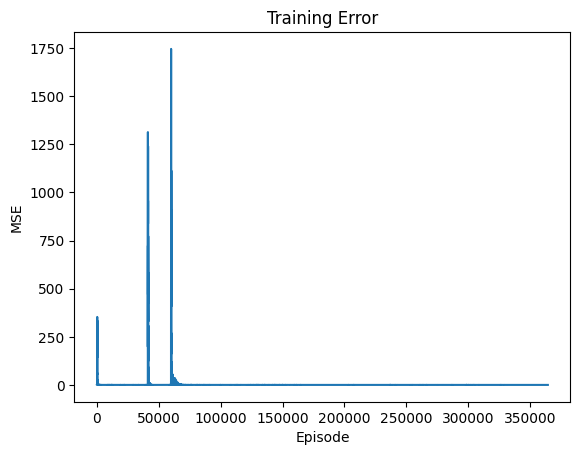

In [51]:
plt.plot(losses_agent0)
plt.xlabel("Episode")
plt.ylabel("MSE")
plt.title("Training Error")
plt.savefig("agent0_connect4_dqn.png", bbox_inches='tight')

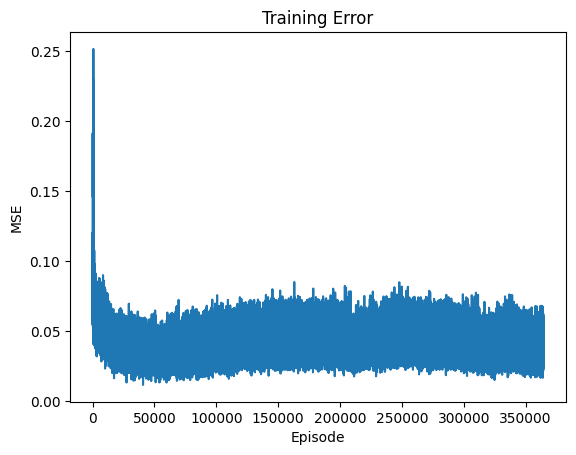

In [52]:
plt.plot(losses_agent1)
plt.xlabel("Episode")
plt.ylabel("MSE")
plt.title("Training Error")
plt.savefig("agent1_connect4_dqn.png", bbox_inches='tight')

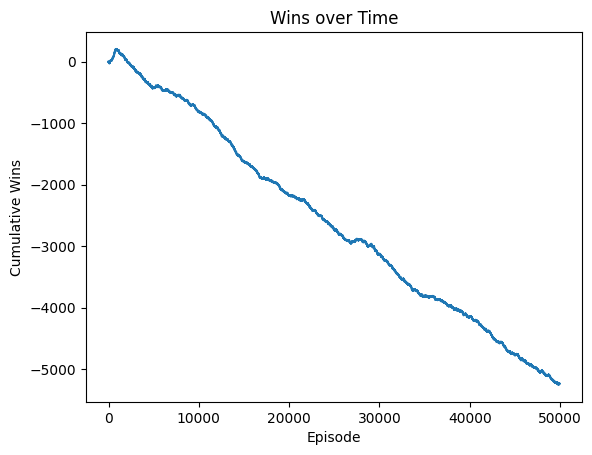

In [53]:
arr = [i for i in rewards_agent1 if i != 0]

plt.plot([sum(arr[:i]) for i in range(len(arr))])
plt.xlabel("Episode")
plt.ylabel("Cumulative Wins")
plt.title("Wins over Time")
plt.savefig("agent1Rainbow_connect4_dqn_cumuWins.png", bbox_inches='tight')

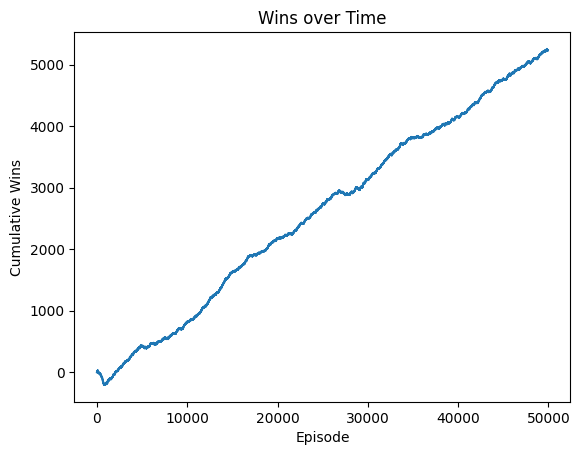

In [54]:
arr = [i for i in rewards_agent0 if i != 0]

plt.plot([sum(arr[:i]) for i in range(len(arr))])
plt.xlabel("Episode")
plt.ylabel("Cumulative Wins")
plt.title("Wins over Time")
plt.savefig("agent0Rainbow_connect4_dqn_cumuWins.png", bbox_inches='tight')

# Now Train with Added Buffer for Key States


In [55]:
agent_0 = DQN()
agent_1 = DQN()
replay_buffer_size = 100_0000
key_state_buffer_agent1 = PrioritizedReplayBuffer(replay_buffer_size)

In [56]:
gamma = 1
returns = []
losses_agent0 = []
losses_agent1 = []
rewards_agent0 = []
rewards_agent1 = []
greedy_agents = False
episodes = 50_000
#env = connect_four_v3.env(render_mode="human")
episode_lengths = []
for episode in tqdm(range(episodes)):
    env.reset()
    #p0
    observation_p0, reward, termination, truncation, info = env.last()
    action_p0 = agent_0.choose_action(observation_p0, greedy=greedy_agents)
    env.step(action_p0)
    #p1
    observation_p1, reward, termination, truncation, info = env.last()
    action_p1 = agent_1.choose_action(observation_p1, greedy=greedy_agents)
    env.step(action_p1)
    #
    for agent in env.agent_iter():
        ######
        observation_p0_prime, reward, termination, truncation, info = env.last()
        #Update
        agent_0.replay_buffer.push(observation_p0["observation"], observation_p0["action_mask"], action_p0, reward, observation_p0_prime["observation"], observation_p0_prime["action_mask"], termination)
        rewards_agent0 += [reward]
        observation_p0 = observation_p0_prime
        #Choose action for player 0 
        if termination or truncation:
            #Update p1 and end
            env.step(None)
            observation_p1_prime, reward, termination, truncation, info = env.last()
            agent_1.replay_buffer.push(observation_p1["observation"],observation_p1["action_mask"], action_p1, reward, observation_p1_prime["observation"],observation_p1_prime["action_mask"], termination)
            if reward != 0:
                key_state_buffer_agent1.push(observation_p1["observation"],observation_p1["action_mask"], action_p1, reward, observation_p1_prime["observation"],observation_p1_prime["action_mask"], termination)
            rewards_agent1+= [reward]
            break
        action_p0 = agent_0.choose_action(observation_p0, greedy=greedy_agents)
        env.step(action_p0)
        ##################################################################
        observation_p1_prime, reward, termination, truncation, info = env.last()
        #Update
        agent_1.replay_buffer.push(observation_p1["observation"],observation_p1["action_mask"], action_p1, reward, observation_p1_prime["observation"],observation_p1_prime["action_mask"], termination)
        if reward != 0:
            key_state_buffer_agent1.push(observation_p1["observation"],observation_p1["action_mask"], action_p1, reward, observation_p1_prime["observation"],observation_p1_prime["action_mask"], termination)
        rewards_agent1+=[reward]
        observation_p1 = observation_p1_prime
        #Choose action for player 1
        if termination or truncation:
            #Update p0 and end
            env.step(None)
            observation_p0_prime, reward, termination, truncation, info = env.last()
            agent_0.replay_buffer.push(observation_p0["observation"], observation_p0["action_mask"], action_p0, reward, observation_p0_prime["observation"], observation_p0_prime["action_mask"], termination)
            rewards_agent0+=[reward]
            break
        action_p1 = agent_1.choose_action(observation_p1, greedy=greedy_agents)
        env.step(action_p1)
        #################
        if len(agent_0.replay_buffer) > agent_0.batch_size:
            loss = agent_0.update()
            losses_agent0 += [loss]
        if len(agent_1.replay_buffer) > agent_1.batch_size:
            loss = agent_1.update()
            losses_agent1 += [loss]
        if len(key_state_buffer_agent1) > agent_1.batch_size:
            loss = agent_1.update_given_buffer(key_state_buffer_agent1)
            losses_agent1 += [loss]
env.close()

100%|██████████| 50000/50000 [7:44:37<00:00,  1.79it/s]   


In [57]:
len(agent_1.replay_buffer)

100000

In [58]:
len(key_state_buffer_agent1)

49960

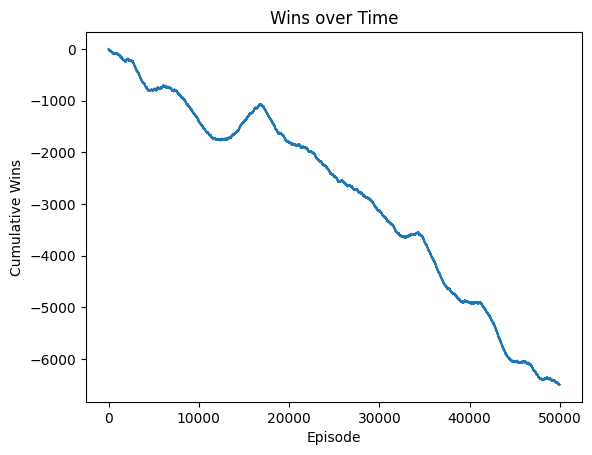

In [59]:
arr = [i for i in rewards_agent1 if i != 0]

plt.plot([sum(arr[:i]) for i in range(len(arr))])
plt.xlabel("Episode")
plt.ylabel("Cumulative Wins")
plt.title("Wins over Time")
plt.savefig("agent1_connect4_dqn_keyStateBuffer_rainbow.png", bbox_inches='tight')

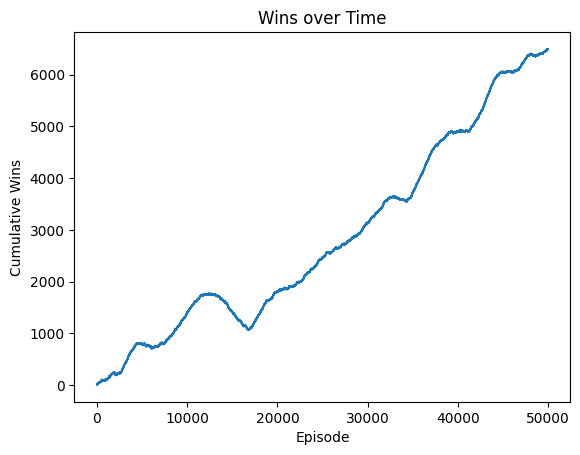

In [60]:
arr = [i for i in rewards_agent0 if i != 0]

plt.plot([sum(arr[:i]) for i in range(len(arr))])
plt.xlabel("Episode")
plt.ylabel("Cumulative Wins")
plt.title("Wins over Time")
plt.savefig("agent0_connect4_dqn_keyStateBuffer.png", bbox_inches='tight')

In [61]:
torch.save(agent_0.q_network.state_dict(), "./agent0_KEY_STATES_MISSING_q_weights.pt")
torch.save(agent_1.q_network.state_dict(), "./agent1_KEY_STATES_q_weights.pt")

In [7]:
agent_0.q_network.load_state_dict(torch.load("./agent0_q_weights.pt"))
agent_1.q_network.load_state_dict(torch.load("./agent1_q_weights.pt"))

<All keys matched successfully>